# Electricity demand
We explore electricity demand in U.S. states and see if they change in tandem with temperatures. We expect the relationship between temperature and electricity demand to be positively correlated during the summer months and negatively correlated during the winter months. These months will be different for different states. 

At the moment the code takes data in the form of excel sheets from EIA website. We should migrate to using their API at some later time as it gives us greater flexibility.    

In [1]:
import pandas as pd
from scipy.fft import rfft, irfft
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

import calendar

# Inputs to the whole code
state = 'TX'    # The state for which we want to do this analysis
consumption_of_interest = 'residential' # Possible values: ('total', 'residential', 'commercial', 'industrial', 'transportation')

In [2]:
# Get the data from EIA
raw_df1 = pd.read_excel("https://www.eia.gov/electricity/data/state/xls/861m/HS861M%202010-.xlsx", header=[0,1,2], index_col=[0,1,2,3])
raw_df1.drop(raw_df1.tail(1).index,inplace=True)  # The last row contains stupid footnote
print(raw_df1.head())

raw_df2 = pd.read_excel("https://www.eia.gov/electricity/data/state/xls/861m/HS861M%201990-2009.xlsx", header=[0,1,2], index_col=[0,1,2,3])
raw_df2.drop(raw_df2.tail(1).index,inplace=True)  # The last row contains stupid footnote
print(raw_df2.head())

                           RESIDENTIAL                                      \
                               Revenue         Sales   Customers     Price   
Data Status           Thousand Dollars Megawatthours       Count Cents/kWh   
2024 3 AK Preliminary         47106.50     190614.23    298721.0     24.71   
       AL Preliminary        327401.61    2062746.90   2389928.0     15.87   
       AR Preliminary        155179.26    1205046.60   1476408.0     12.88   
       AZ Preliminary        319355.65    2136693.50   3084292.0     14.95   
       CA Preliminary       1921809.30    5918231.40  14111959.0     32.47   

                            COMMERCIAL                                     \
                               Revenue         Sales  Customers     Price   
Data Status           Thousand Dollars Megawatthours      Count Cents/kWh   
2024 3 AK Preliminary         48420.99     227281.61    57410.0     21.30   
       AL Preliminary        230487.76    1659707.40   383817.0    

In [3]:
# Debug prints
print("Temp dataframe indices")
print(raw_df1.index)
print("Temp dataframe columns")
print(raw_df1.columns)
raw_df1.loc[(2024, 2, 'AK', 'Preliminary'), ('TOTAL', 'Sales', 'Megawatthours')]    # Just make sure we are interpreting the multiindex indices and columns correctly

Temp dataframe indices
MultiIndex([(2024, 3, 'AK', 'Preliminary'),
            (2024, 3, 'AL', 'Preliminary'),
            (2024, 3, 'AR', 'Preliminary'),
            (2024, 3, 'AZ', 'Preliminary'),
            (2024, 3, 'CA', 'Preliminary'),
            (2024, 3, 'CO', 'Preliminary'),
            (2024, 3, 'CT', 'Preliminary'),
            (2024, 3, 'DC', 'Preliminary'),
            (2024, 3, 'DE', 'Preliminary'),
            (2024, 3, 'FL', 'Preliminary'),
            ...
            (2010, 1, 'SD',       'Final'),
            (2010, 1, 'TN',       'Final'),
            (2010, 1, 'TX',       'Final'),
            (2010, 1, 'UT',       'Final'),
            (2010, 1, 'VA',       'Final'),
            (2010, 1, 'VT',       'Final'),
            (2010, 1, 'WA',       'Final'),
            (2010, 1, 'WI',       'Final'),
            (2010, 1, 'WV',       'Final'),
            (2010, 1, 'WY',       'Final')],
           length=8721)
Temp dataframe columns
MultiIndex([(   'RESIDENTIAL',   

553116.21

In [4]:
temp_df1 = raw_df1['TOTAL']['Sales']
temp_df2 = raw_df2['TOTAL']['Sales']

In [5]:
temp_df1.rename(columns={'Megawatthours':'total (MWh)'}, inplace=True)
temp_df1.loc[:,'residential (MWh)'] = raw_df1['RESIDENTIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'commercial (MWh)'] = raw_df1['COMMERCIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'industrial (MWh)'] = raw_df1['INDUSTRIAL']['Sales']['Megawatthours']
temp_df1.loc[:,'transportation (MWh)'] = raw_df1['TRANSPORTATION']['Sales']['Megawatthours']
print(temp_df1.head())
print(raw_df1.loc[(2024, 2, 'VA', 'Preliminary'), ('RESIDENTIAL', 'Sales', 'Megawatthours')])
print(temp_df1.loc[(2024, 2, 'VA', 'Preliminary'), 'residential (MWh)'])

Data Status            total (MWh)  residential (MWh)  commercial (MWh)  \
2024 3 AK Preliminary     537507.8          190614.23         227281.61   
       AL Preliminary    6299653.7         2062746.90        1659707.40   
       AR Preliminary    3647641.5         1205046.60         853576.54   
       AZ Preliminary    5683847.3         2136693.50        2385275.30   
       CA Preliminary   17658398.0         5918231.40        8700462.70   

Data Status            industrial (MWh)  transportation (MWh)  
2024 3 AK Preliminary         119611.96                  0.00  
       AL Preliminary        2577199.50                  0.00  
       AR Preliminary        1588999.80                 18.62  
       AZ Preliminary        1161041.40                837.14  
       CA Preliminary        2975249.50              64454.59  
4026306.6
4026306.6


In [6]:
temp_df2.rename(columns={'Megawatthours':'total (MWh)'}, inplace=True)
temp_df2.loc[:,'residential (MWh)'] = raw_df2['RESIDENTIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'commercial (MWh)'] = raw_df2['COMMERCIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'industrial (MWh)'] = raw_df2['INDUSTRIAL']['Sales']['Megawatthours']
temp_df2.loc[:,'transportation (MWh)'] = raw_df2['TRANSPORTATION']['Sales']['Megawatthours']
print(temp_df2.head())
print(raw_df2.loc[(2007, 2, 'VA', 'Final'), ('RESIDENTIAL', 'Sales', 'Megawatthours')])
print(temp_df2.loc[(2007, 2, 'VA', 'Final'), 'residential (MWh)'])

Data Status       total (MWh)  residential (MWh) commercial (MWh)  \
2009 12 AK Final     594006.0           222134.0           256270   
        AL Final    6964800.0          2818685.0          1679995   
        AR Final    3621183.0          1448385.0           889269   
        AZ Final    5341392.0          2284523.0          2156813   
        CA Final   21942679.0          8064319.0         10031863   

Data Status      industrial (MWh) transportation (MWh)  
2009 12 AK Final           115603                    0  
        AL Final          2466120                    0  
        AR Final          1283489                   39  
        AZ Final           900056                    0  
        CA Final          3778341                68156  
4654894.0
4654894.0


In [7]:
combined_temp_df = pd.concat([temp_df1, temp_df2])
print(combined_temp_df.head())
print(combined_temp_df.tail())

Data Status            total (MWh)  residential (MWh) commercial (MWh)  \
2024 3 AK Preliminary     537507.8          190614.23        227281.61   
       AL Preliminary    6299653.7         2062746.90        1659707.4   
       AR Preliminary    3647641.5         1205046.60        853576.54   
       AZ Preliminary    5683847.3         2136693.50        2385275.3   
       CA Preliminary   17658398.0         5918231.40        8700462.7   

Data Status           industrial (MWh) transportation (MWh)  
2024 3 AK Preliminary        119611.96                  0.0  
       AL Preliminary        2577199.5                  0.0  
       AR Preliminary        1588999.8                18.62  
       AZ Preliminary        1161041.4               837.14  
       CA Preliminary        2975249.5             64454.59  
Data Status      total (MWh)  residential (MWh) commercial (MWh)  \
1990 1 VT Final     467347.0           207079.0           136452   
       WA Final    8602023.0          3331947.0

In [8]:
sales = combined_temp_df.rename_axis(['year','month', 'state','Data Status']).reset_index()
sales.rename_axis(None, axis=1, inplace=True)
sales = sales[(sales['Data Status'] == 'Final')]
print(sales.head())
print(sales.tail())

     year  month state Data Status  total (MWh)  residential (MWh)  \
765  2022     12    AK       Final    579948.87          225218.32   
766  2022     12    AL       Final   7066254.30         2861596.70   
767  2022     12    AR       Final   3951564.30         1640500.90   
768  2022     12    AZ       Final   6102137.70         2618358.20   
769  2022     12    CA       Final  19176141.00         6817678.20   

    commercial (MWh) industrial (MWh) transportation (MWh)  
765        238154.09        116576.47                  0.0  
766        1754864.5        2449793.1                  0.0  
767        892904.69        1418137.0                21.69  
768        2305656.1        1177319.8               803.55  
769        8861330.8        3435592.4             61540.03  
       year  month state Data Status  total (MWh)  residential (MWh)  \
20956  1990      1    VT       Final     467347.0           207079.0   
20957  1990      1    WA       Final    8602023.0          3331947.0 

In [9]:
# Format date and drop useless columns
sales.loc[:,'temp col'] = sales['month'].map(str)+ '-' +sales['year'].map(str)     # Without using loc, you get warnings
sales.loc[:,'date'] = pd.to_datetime(sales['temp col'], format='%m-%Y')
sales.drop(columns=['year', 'month', 'Data Status', 'temp col'], inplace=True)
sales.sort_values(by=['date'], ascending=True, inplace=True)
print(sales.head())

      state  total (MWh)  residential (MWh) commercial (MWh) industrial (MWh)  \
20960    WY    1056455.0           195508.0           192662           653016   
20931    ME    1095864.0           440117.0           248913           391657   
20930    MD    5024470.0          2333681.0           966266          1662862   
20929    MA    4421928.0          1767550.0          1698605           840363   
20928    LA    5137775.0          1808037.0          1085651          1987988   

      transportation (MWh)       date  
20960                    . 1990-01-01  
20931                    . 1990-01-01  
20930                    . 1990-01-01  
20929                    . 1990-01-01  
20928                    . 1990-01-01  


Start year: 1990
End year: 2022


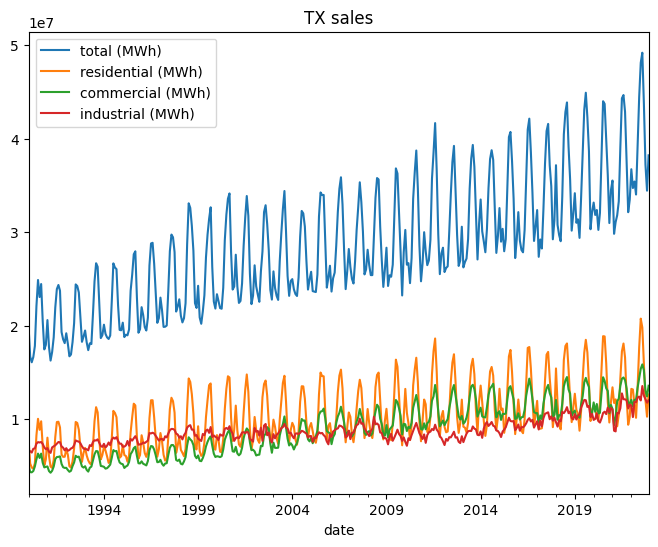

In [10]:
# Visualize sales for a state
state_sales = sales[sales.state == state]
if state_sales.index.size%12 != 0:
    print("MAJOR ISSUE: We need to have 12 full months of data for each year in the state sales. Otherwise FFT down the line will fail. STOP EXECUTION")

data_start_year = np.min(state_sales['date'].dt.year.values)
data_end_year = np.max(state_sales['date'].dt.year.values)
total_years = data_end_year - data_start_year     # This will be useful later
print("Start year: " + str(data_start_year))
print("End year: " + str(data_end_year))
state_sales.set_index('date', inplace=True)
ax = state_sales.plot(title = state+' sales', figsize=(8,6))

In [11]:
# Find the month every year when energy use goes from positively correlated with temperature to negatively correlated with temperature
col_of_interest = consumption_of_interest+' (MWh)'
state_sales_vals = state_sales[col_of_interest].values
state_sales_freq_domain = rfft(state_sales_vals)
ind = np.abs(state_sales_freq_domain).argsort()[:len(state_sales_freq_domain)-3] 
state_sales_freq_domain[ind] = 0    # Keep only top two harmonics and DC
state_sales_freq_domain[0] = 0  # Comment out this line if you want to keep the DC signal as well
state_sales_harmonics = irfft(state_sales_freq_domain)

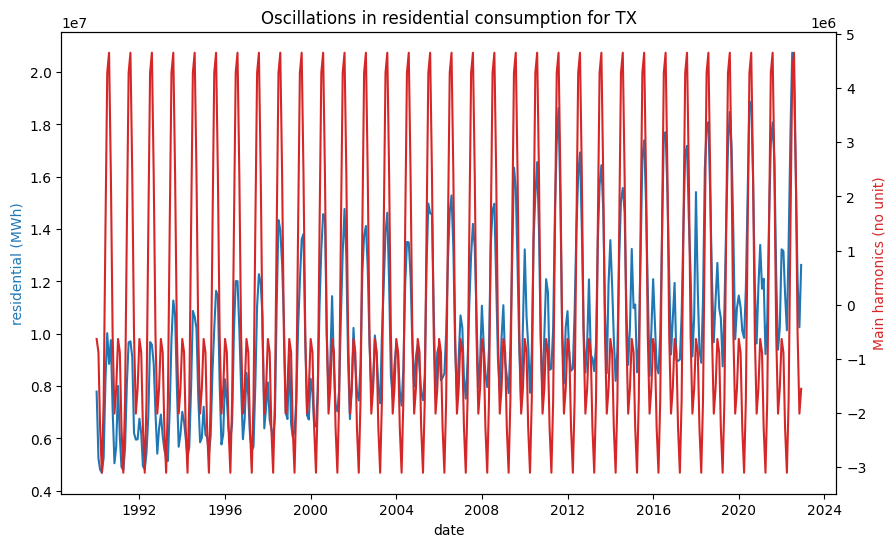

In [12]:
fig, ax1= plt.subplots(1,1, figsize=(10,6)) 
color = 'tab:blue'
# ax1.plot(np.abs(state_sales_freq_domain))
ax1.plot(state_sales.index.values, state_sales[col_of_interest].values, color=color)
ax1.set_xlabel('date')
ax1.set_ylabel(col_of_interest, color=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(state_sales.index.values, state_sales_harmonics, color=color)
ax2.set_ylabel('Main harmonics (no unit)', color=color)

plt.title('Oscillations in {} consumption for {}'.format(consumption_of_interest, state))
plt.show()

In [13]:
# Find the months that have positive correlation with temperature and the months that have negative correlation with temperature
least_consumption_month = np.argmin(state_sales_harmonics)
temp_array = state_sales_harmonics.copy()
least_consumption_months = np.arange(start=least_consumption_month, step=12, stop=len(temp_array))
temp_array[least_consumption_months] = 0
second_least_consumption_month = np.argmin(temp_array)

print("Least consumption month: "+calendar.month_name[least_consumption_month+1])
print("Second least consumption month: "+calendar.month_name[second_least_consumption_month+1])
print("Least consumption amount (MWh)"+str(state_sales.loc[state_sales.index.values[least_consumption_month], col_of_interest]))
print("Second least consumption amount (MWh)"+str(state_sales.loc[state_sales.index.values[second_least_consumption_month], col_of_interest]))

ac_months = []
heater_months = []
if least_consumption_month < second_least_consumption_month:
    for month in range(0,len(state_sales_harmonics)):
        if month%12 in range(least_consumption_month, second_least_consumption_month):
            ac_months.append(month)
        else:
            heater_months.append(month)
else:
    for month in range(0,len(state_sales_harmonics)):
        if month%12 in range(second_least_consumption_month, least_consumption_month):
            heater_months.append(month)
        else:
            ac_months.append(month)

print("AC months: ")
print(ac_months)
print("Heater months: ")
print(heater_months)


Least consumption month: April
Second least consumption month: March
Least consumption amount (MWh)4690621.0
Second least consumption amount (MWh)4811408.0
AC months: 
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 2

In [14]:
# Get the temperature data (from NCEI - NOAA - https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)
temp_raw = pd.read_csv("C:/Users/dinesh/OneDrive - Fordham University/Planette/Code/texas_temp_1990_2022.csv")
temp_raw.loc[:,'date'] = pd.to_datetime(temp_raw['Date'], format='%Y%m')    # Massage the dates to make them usable in this code
temp_raw.drop(columns=['Date'], inplace=True)
temp_raw.set_index('date', inplace=True)

# Merge temperature into state_sales data
state_sales.loc[:,'temperature'] = temp_raw.loc[:,'Value']
state_sales.loc[:,'consumption (MWh)'] = signal.detrend(state_sales.loc[:,col_of_interest]) # We use a detrended version of consumption type we are interested in 
print(temp_raw.head())
print(state_sales.head())

            Value  Anomaly
date                      
1990-01-01   50.2      4.8
1990-02-01   53.3      3.9
1990-03-01   57.3      1.0
1990-04-01   64.7     -0.1
1990-05-01   72.8      0.3
           state  total (MWh)  residential (MWh) commercial (MWh)  \
date                                                                
1990-01-01    TX   19863849.0          7791226.0          5054850   
1990-02-01    TX   16698262.0          5239001.0          4325037   
1990-03-01    TX   16074721.0          4811408.0          4297893   
1990-04-01    TX   16629218.0          4690621.0          4441648   
1990-05-01    TX   17817832.0          5273155.0          4938595   

           industrial (MWh) transportation (MWh)  temperature  \
date                                                            
1990-01-01          6422217                    .         50.2   
1990-02-01          6567511                    .         53.3   
1990-03-01          6415820                    .         57.3   
19

C:\Users\dinesh\AppData\Local\Temp\ipykernel_4856\2211544495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_sales.loc[:,'temperature'] = temp_raw.loc[:,'Value']
C:\Users\dinesh\AppData\Local\Temp\ipykernel_4856\2211544495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_sales.loc[:,'consumption (MWh)'] = signal.detrend(state_sales.loc[:,col_of_interest]) # We use a detrended version of consumption type we are interested in


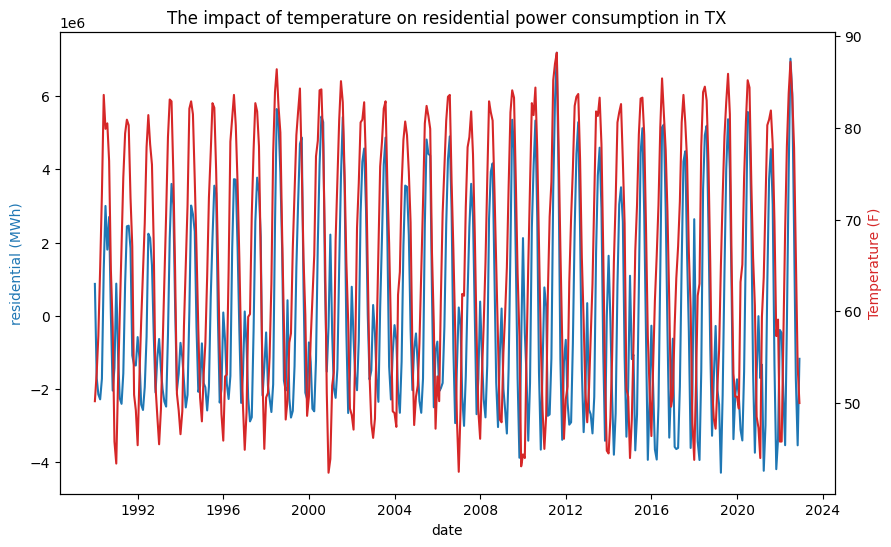

In [15]:
# Visualize temperature and consumption in relationship with each other
fig, ax1= plt.subplots(1,1, figsize=(10,6)) 
color = 'tab:blue'
ax1.plot(state_sales.index.values, state_sales['consumption (MWh)'].values, color=color)
ax1.set_xlabel('date')
ax1.set_ylabel(col_of_interest, color=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(state_sales.index.values, state_sales['temperature'].values, color=color)
ax2.set_ylabel('Temperature (F)', color=color)

plt.title('The impact of temperature on {} power consumption in {}'.format(consumption_of_interest, state))
plt.show()

In [16]:
# Temperature based segmentation of cold and warm months
temp_thresh = 65    # Farenheit
cold_months_data = state_sales[state_sales.temperature < temp_thresh]
warm_months_data = state_sales[state_sales.temperature >= temp_thresh]

In [17]:
# Manual segmentation of cold and warm months. December, Jan, Feb are used to represent cold months. 
cold_months_data = state_sales[(state_sales.index.month.isin([12,1,2]))]
print(cold_months_data.head())
warm_months_data = state_sales[~(state_sales.index.month.isin([12,1,2]))]
print(warm_months_data.head())

           state  total (MWh)  residential (MWh) commercial (MWh)  \
date                                                                
1990-01-01    TX   19863849.0          7791226.0          5054850   
1990-02-01    TX   16698262.0          5239001.0          4325037   
1990-12-01    TX   17941179.0          5687574.0          4887294   
1991-01-01    TX   20588421.0          8008058.0          4927635   
1991-02-01    TX   17694393.0          6051952.0          4435104   

           industrial (MWh) transportation (MWh)  temperature  \
date                                                            
1990-01-01          6422217                    .         50.2   
1990-02-01          6567511                    .         53.3   
1990-12-01          6771360                    .         45.8   
1991-01-01          6893727                    .         43.4   
1991-02-01          6509542                    .         52.5   

            consumption (MWh)  
date                        

In [39]:
# Run regression between temperature as the independent variable and power consumption as the dependent variable
# We run two regressions, one for cold months and one for warm months. We do this because power consumption and temperature are typically 
# negatively correlated during winter months and positively correlated during the other months. We exclude last 10 years from training 
# because want to do hindcasting for those years

last_training_year = data_end_year-10+1

# Build the model for cold months
training_data = cold_months_data[cold_months_data.index.year < last_training_year]
#temperature = training_data['temperature'].values.reshape((-1,1))
temperature = np.array([training_data['temperature'].values, training_data['temperature'].values**2]).T
print(temperature)
consumption = training_data['consumption (MWh)'].values
cold_model = LinearRegression()
cold_model.fit(temperature, consumption)


# Build the model for cold months
training_data = warm_months_data[warm_months_data.index.year < last_training_year]
#temperature = training_data['temperature'].values.reshape((-1,1))
temperature = np.array([training_data['temperature'].values, training_data['temperature'].values**2]).T
consumption = training_data['consumption (MWh)'].values
warm_model = LinearRegression()
warm_model.fit(temperature, consumption)



[[  50.2  2520.04]
 [  53.3  2840.89]
 [  45.8  2097.64]
 [  43.4  1883.56]
 [  52.5  2756.25]
 [  49.2  2420.64]
 [  45.4  2061.16]
 [  53.   2809.  ]
 [  48.6  2361.96]
 [  45.5  2070.25]
 [  49.3  2430.49]
 [  49.2  2420.64]
 [  46.6  2171.56]
 [  49.1  2410.81]
 [  50.6  2560.36]
 [  48.   2304.  ]
 [  53.2  2830.24]
 [  48.8  2381.44]
 [  45.9  2106.81]
 [  52.9  2798.41]
 [  49.8  2480.04]
 [  44.9  2016.01]
 [  49.   2401.  ]
 [  45.   2025.  ]
 [  50.6  2560.36]
 [  51.1  2611.21]
 [  48.2  2323.24]
 [  50.3  2530.09]
 [  56.6  3203.56]
 [  48.6  2361.96]
 [  50.7  2570.49]
 [  57.   3249.  ]
 [  42.4  1797.76]
 [  43.9  1927.21]
 [  51.9  2693.61]
 [  49.4  2440.36]
 [  48.7  2371.69]
 [  47.1  2218.41]
 [  47.8  2284.84]
 [  46.2  2134.44]
 [  48.3  2332.89]
 [  49.1  2410.81]
 [  48.9  2391.21]
 [  47.4  2246.76]
 [  47.6  2265.76]
 [  50.7  2570.49]
 [  51.9  2693.61]
 [  47.2  2227.84]
 [  52.9  2798.41]
 [  50.2  2520.04]
 [  48.2  2323.24]
 [  42.5  1806.25]
 [  49.4  24

LinearRegression()

In [40]:
test_data_cold = cold_months_data[cold_months_data.index.year >= last_training_year]
#test_data_cold.loc[:, 'hindcast (MWh)'] = cold_model.predict(test_data_cold['temperature'].values.reshape((-1,1)))
indep_var = np.array([test_data_cold['temperature'].values, test_data_cold['temperature'].values**2]).T
test_data_cold.loc[:, 'hindcast (MWh)'] = cold_model.predict(indep_var)

test_data_warm = warm_months_data[warm_months_data.index.year >= last_training_year]
#test_data_warm.loc[:, 'hindcast (MWh)'] = warm_model.predict(test_data_warm['temperature'].values.reshape((-1,1)))
indep_var = np.array([test_data_warm['temperature'].values, test_data_warm['temperature'].values**2]).T
test_data_warm.loc[:, 'hindcast (MWh)'] = warm_model.predict(indep_var)

r2_cold = metrics.r2_score(test_data_cold['consumption (MWh)'], test_data_cold['hindcast (MWh)'])
r2_warm = metrics.r2_score(test_data_warm['consumption (MWh)'], test_data_warm['hindcast (MWh)'])

C:\Users\dinesh\AppData\Local\Temp\ipykernel_4856\869915870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_cold.loc[:, 'hindcast (MWh)'] = cold_model.predict(indep_var)
C:\Users\dinesh\AppData\Local\Temp\ipykernel_4856\869915870.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_warm.loc[:, 'hindcast (MWh)'] = warm_model.predict(indep_var)


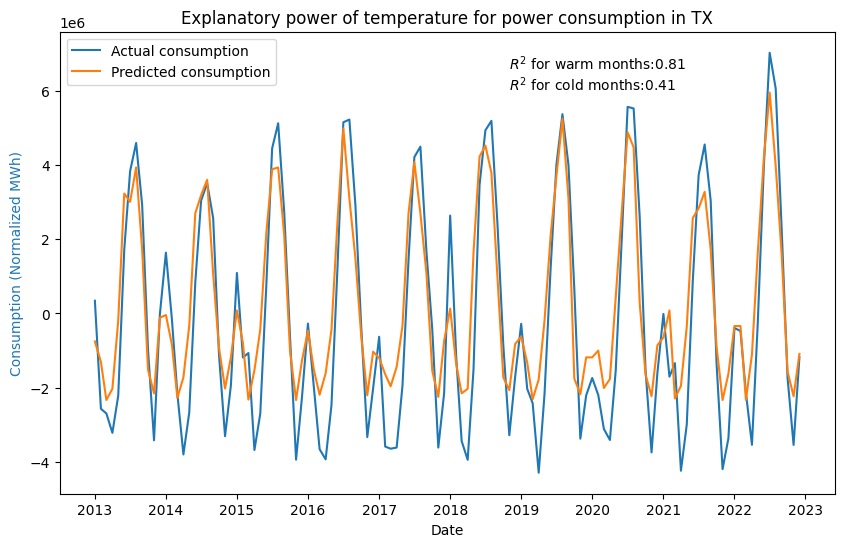

In [41]:

test_data_combined = pd.concat([test_data_warm, test_data_cold], sort=False).sort_index()
# test_data_combined.plot(y=['consumption (MWh)', 'hindcast (MWh)'])
fig, ax = plt.subplots(1,1,figsize=(10,6))

color = 'tab:blue'
ax.plot(test_data_combined.index.values, test_data_combined['consumption (MWh)'].values, color=color, label='Actual consumption')
ax.set_xlabel("Date")
ax.set_ylabel('Consumption (Normalized MWh)', color=color)

color = 'tab:orange'
ax.plot(test_data_combined.index.values, test_data_combined['hindcast (MWh)'].values, color=color, label='Predicted consumption')

plt.title('Explanatory power of temperature for power consumption in {}'.format(state))
plt.legend()
text_str = '$R^2$ for warm months:%.2f\n$R^2$ for cold months:%.2f'%(r2_warm, r2_cold)
plt.text(x=test_data_combined.index.values[-50], y=6*1e6, s=text_str, fontsize = 10)
plt.show()